In [239]:
# conda activate chronocell

import os
import sys
import numpy as np
import anndata as ad

sys.path.append("/mnt/lareaulab/reliscu/programs/FGP_2024")

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *
from Chronocell.models.two_species_ss import get_Y

2024.10


In [240]:
# Ref: https://www.nature.com/articles/nature10098#Fig2

In [241]:
n = 1000

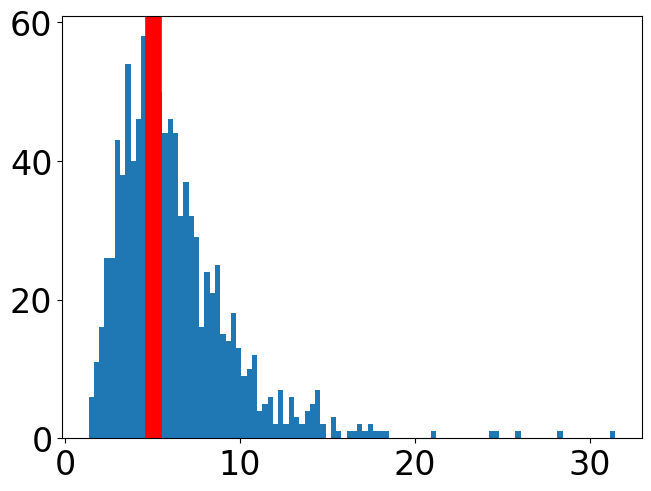

In [242]:
# betaing rate
beta_mu = 2
beta_sd = 0.5

beta = np.random.lognormal(beta_mu, beta_sd, size=n)
plt.hist(60*np.log(2)/beta, bins=100);
plt.axvline(x=5, color='r');

/tmp/ipykernel_16981/2650645985.py:29: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


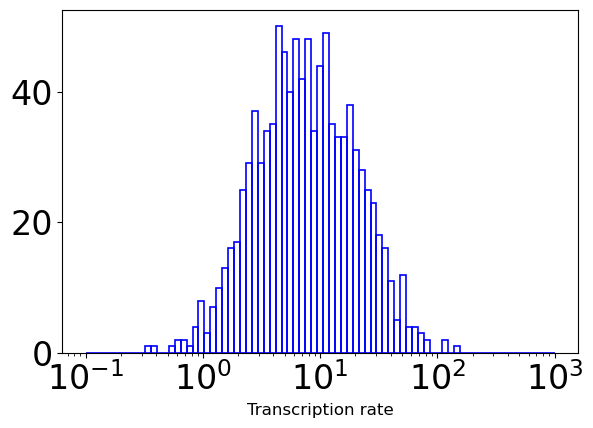

/tmp/ipykernel_16981/2650645985.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


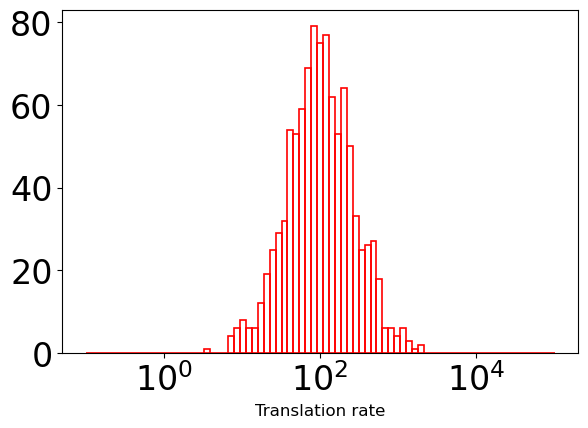

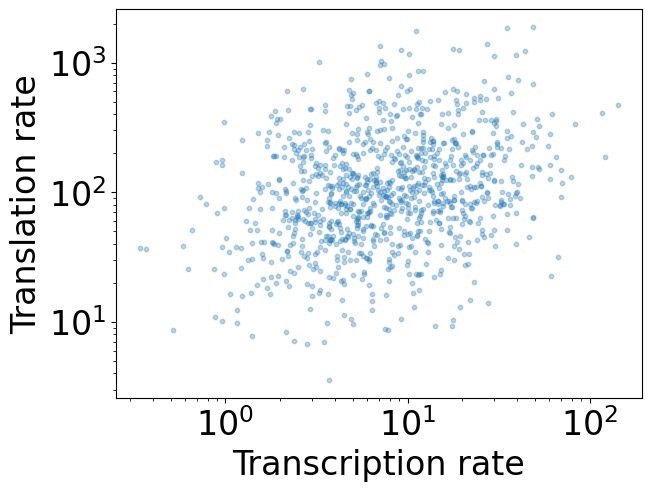

In [243]:
# Transcription rate
alpha_mu = 2
alpha_sd = 1

# Translation rate
transl_rate_mu = np.log(100)
transl_rate_sd = 1

# Transcription rates and translation rates are assumed to be correlated

rho = .3
cov = [[alpha_sd**2, rho * alpha_sd * transl_rate_sd],
       [rho * alpha_sd * transl_rate_sd, transl_rate_sd**2]]

np.random.seed(0)
log_vals = np.random.multivariate_normal(mean=[alpha_mu, transl_rate_mu], cov=cov, size=n)

# Exponentiate to get correlated log-normal variables
alpha = np.exp(log_vals[:, 0])
transl_rate = np.exp(log_vals[:, 1])

# Plot

# Transcription rates
log_bins = np.logspace(-1, 3, 80)
plt.hist(alpha, bins=log_bins, edgecolor='blue', facecolor='none', linewidth=1.2)
plt.xscale('log')
plt.xlabel('Transcription rate', fontsize=12)
plt.tight_layout()
plt.show()

# Translation rates
log_bins = np.logspace(-1, 5, 80)
plt.hist(transl_rate, bins=log_bins, edgecolor='red', facecolor='none', linewidth=1.2)
plt.xscale('log')
plt.xlabel('Translation rate', fontsize=12)
plt.tight_layout()
plt.show()

# Plot alpha vs. beta
plt.scatter(alpha, transl_rate, alpha=0.3, s=10);
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Transcription rate')
plt.ylabel('Translation rate')
plt.show()

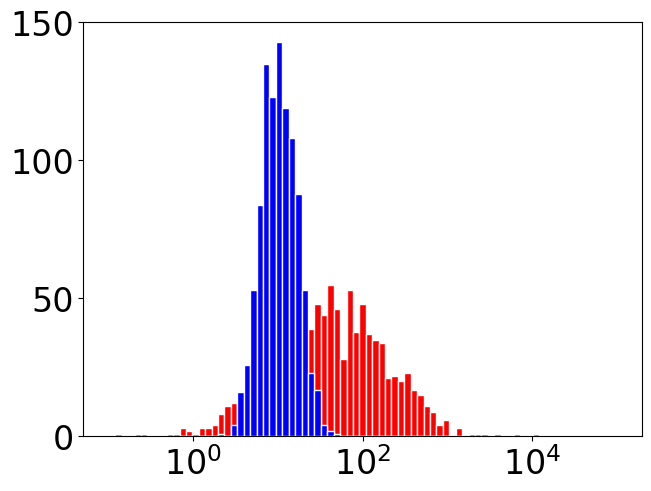

In [244]:
# mRNA degradation rate
rna_median_half_life = 10
gamma_rate = np.log(2) / rna_median_half_life
gamma_mu = np.log(gamma_rate) # Median of lognormal
gamma_sd = 0.5
gamma = np.random.lognormal(gamma_mu, gamma_sd, size=n)
rna_half_lives = np.log(2) / gamma

# Protein degradation rate
protein_median_half_life = 40
deg_rate = np.log(2) / protein_median_half_life
deg_rate_mu = np.log(deg_rate) # Median of lognormal
deg_rate_sd = 1.5
deg_rate = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=n)
protein_half_lives = np.log(2) / deg_rate

log_bins = np.logspace(-1, 5, 80)
plt.hist(protein_half_lives, bins=log_bins, color='red', edgecolor='white')
plt.hist(rna_half_lives, bins=log_bins, color='blue', edgecolor='white')
# plt.axvline(target_half_life_median, color='black', label='Target median ≈ 50 h')
plt.xscale('log')

In [321]:
# Simulate data

n = 2000 # No. cells per lineage
p = 500 # No. genes
m = 101 # No. time steps

topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 3)
L = len(topo)
n_states = len(set(topo.flatten()))

# Read depth
rd_mu = 0.25
rd_var = 1/64
a = (1-rd_mu)/rd_var - rd_mu
b = (1/rd_mu-1)*a
rd = np.random.beta(a=a, b=b, size=n*L)

In [322]:
# Generate correlated transcription and translation rates per gene per cell state
np.random.seed(0)
rho = .1
cov = [[alpha_sd**2, rho * alpha_sd * transl_rate_sd],
       [rho * alpha_sd * transl_rate_sd, transl_rate_sd**2]]
log_vals = np.random.multivariate_normal(mean=[alpha_mu, transl_rate_mu], cov=cov, size=(p, n_states))

# Exponentiate to get log-normal variables
alpha = np.exp(log_vals[:,:, 0])
transl_rate = np.exp(log_vals[:, :, 1]) 

In [323]:
# RNA production parameters per gene

np.random.seed(0)
theta = np.zeros((p, n_states + 2))
theta[:,:n_states] = alpha
theta[:,-2] = np.random.lognormal(beta_mu, beta_sd, size=p) # Generate betaing rates per gene
theta[:,-1] = np.random.lognormal(gamma_mu, gamma_sd, size=p) # Generate degradation rates per gene
# theta[:,:n_states] /= theta[:,-2, None] # Normalize by betaing rate - not sure why they do this????

# Simulate RNA counts

true_t = []
true_l = []

Y = np.zeros((n*L, p, 2))
for l in range(L):
    theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
    t = np.sort(np.random.uniform(tau[0], tau[-1], size=n)) # EACH TIME POINT IS A CELL
    Y[l*n:(l+1)*n] = get_Y(theta_l, t, tau) # Cells x genes x RNA species
    true_t = np.append(true_t, t)
    true_l = np.append(true_l, np.full(len(t), l))

# theta[:,:n_states] #*= rd_mu 

# Z = rd[:,None,None]*Y
# X = np.random.poisson(Z)
X = np.random.poisson(Y)

In [324]:
# Protein production parameters per gene

np.random.seed(0)
phi = np.zeros((p, n_states + 1))
phi[:,:n_states] = transl_rate # Translation rate per gene
phi[:,-1] = np.random.lognormal(deg_rate_mu, deg_rate_sd, size=p) # Degradation rate per gene

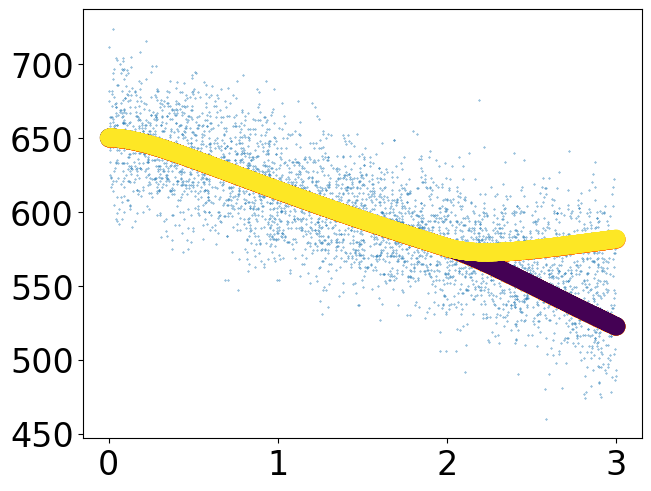

In [325]:
idx = 19
plt.scatter(true_t, X[:, idx, 1], s=.1)
plt.scatter(true_t, Y[:, idx, 1])
plt.scatter(true_t, Y[:, idx, 1], c=true_l)

In [326]:
# Inputs

n = 2000 # No. cells per lineage
topo = np.array([[0, 1, 2], [0, 1, 3]])
tau = (0, 2, 3)
# true_t
# phi

In [ ]:
p = len(phi)
L = len(topo)
K = len(tau)-1 # No. states per lineage

y0 = X[0, :, 1] # Steady-state spliced RNA levels
p0 = phi[:,0] * y0

P = np.zeros((n*L, p))

for l in range(L):
    
    t_l = true_t[true_l == l].reshape((-1, 1)) # Time points/cells in lineage l     
    y_l = X[l*n:(l+1)*n, :, 1] # Counts from cells in lineage l

    # Protein production paramters for lineage l:
    phi_l = np.concatenate((phi[:,topo[l]], phi[:,-1:]), axis=1) 
    transl_rate = phi_l[:, 1:(K+1)].T 
    deg_rate = phi[:, -1].reshape((1, -1))

    t_diff = t_l - t_l.T 
    # Rows: target time; columns: past times, e.g. t_diff[m, i] = time difference between t_m and t_i 
    
    t_diff[t_diff < 0] = 0 
    # Time contributions can't be negative
    
    decay_matrix = np.exp(-t_diff[:, :, None] * deg_rate) 
    # E.g. decay_matrix[m, i, p] = decay factor for protein abundance at t_m from RNA available at t_i (for gene p)

    p_l = p0 * np.exp(-deg_rate * t_l) 
    # Pre-existing protein that has not yet degraded

    for k in range(1, K+1):
        I_k = (t_l[:, 0] > tau[k-1]) & (t_l[:, 0] <= tau[k]) 
        y_l_masked = np.zeros_like(y_l) 
        y_l_masked[I_k] = y_l[I_k] # Only include cells in state k
        protein_contrib = np.einsum('mip, ip -> mp', decay_matrix, y_l) # Integrate RNA counts still surviving up at each time point
        p_l += transl_rate[k-1] * protein_contrib # Newly synthesized protein
        
    P[l*n:(l+1)*n] = p_l
    
P1 = np.random.poisson(P)

In [315]:
# for l in range(L):
l = 0

data = np.zeros((p, 3))
for i in range(p):
    phi_l = np.concatenate((phi[:,topo[l]], phi[:,-1:]), axis=1) 
    transl_rate = phi_l[i, 1:(K+1)]
    cor = np.corrcoef(X[l*n:(l+1)*n, i, 1], P1[l*n:(l+1)*n, i])[0,1]
    data[i, 0] = np.corrcoef(X[l*n:(l+1)*n, i, 1], P1[l*n:(l+1)*n, i])[0,1]
    data[i, 1] = np.max(transl_rate)
    data[i, 2] = phi[i, -1]


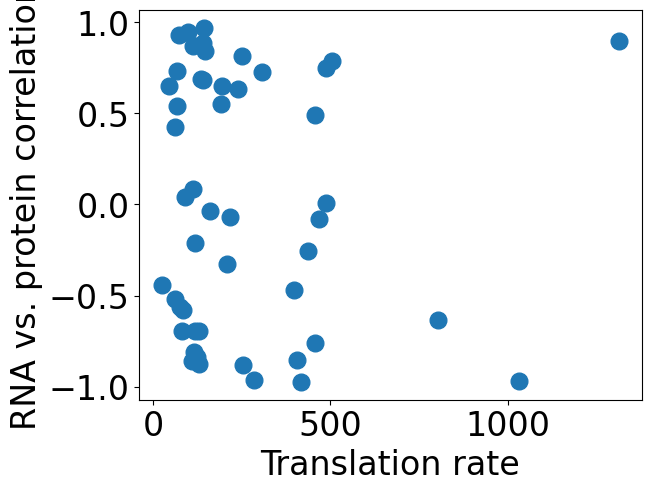

In [ ]:
plt.scatter(data[:, 1], data[:, 0], s=0.3);
plt.xlabel("Translation rate");
plt.ylabel("RNA vs. protein correlation");

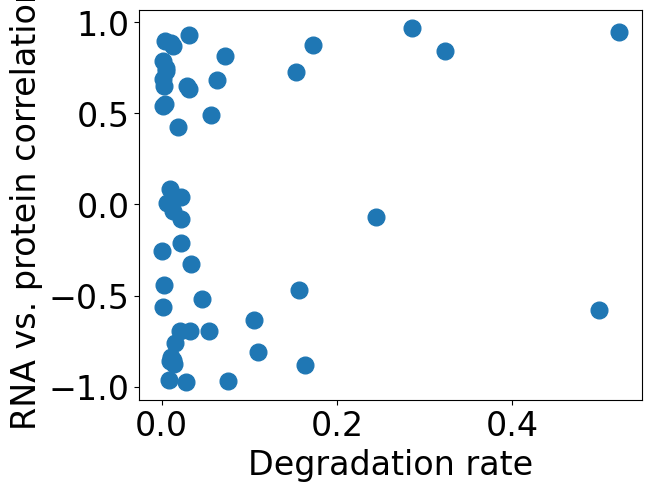

In [ ]:
plt.scatter(data[:, 2], data[:, 0], s=0.3);
plt.xlabel("Degradation rate");
plt.ylabel("RNA vs. protein correlation");

In [308]:
data

array([], shape=(0, 3), dtype=float64)

In [306]:
np.max(transl_rate, axis=1)

array([ 217.57759106,  238.38831992, 1029.65470813,   85.97929615,
        143.7493012 , 1311.85040758,  251.84354648,  129.37104692,
        456.96253721,  129.36870118,  118.30356926,  306.19289992,
        119.1892209 ,   82.31145644,  208.97840482,  195.14786342,
        254.14236019,  405.80361274,  416.32015697,   68.93125939,
        437.20115318,   62.55536558,  141.84394986,  487.22714986,
         98.02459088,   68.66262893,   62.98898625,  161.10016941,
        132.76078375,  398.08344494,   90.37366106,   72.65214307,
        487.14589431,  134.43321856,  124.80466603,  468.2681721 ,
        115.38675654,  801.45137817,  108.99229426,  141.72628997,
        191.32925795,   25.88003868,  505.58024122,  145.58415423,
        284.68759968,  112.70279807,   45.31589402,  456.83158851,
         77.37839225,  113.79415724])

In [304]:
np.zeros((i, 3))

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [303]:
phi[:, -1]

array([2.44310858e-01, 3.15823594e-02, 7.52239663e-02, 4.99547507e-01,
       2.85345261e-01, 4.00060694e-03, 7.20597424e-02, 1.38090903e-02,
       1.48430928e-02, 3.20808942e-02, 2.15080710e-02, 1.53511144e-01,
       5.42671728e-02, 2.07983869e-02, 3.37222465e-02, 2.85847796e-02,
       1.62956210e-01, 1.27384568e-02, 2.77147415e-02, 4.81251249e-03,
       3.76392868e-04, 4.61912690e-02, 6.33716882e-02, 5.69230563e-03,
       5.21648944e-01, 1.95582948e-03, 1.85598506e-02, 1.30865781e-02,
       1.72695810e-01, 1.57024377e-01, 2.18627449e-02, 3.05573939e-02,
       4.57535496e-03, 8.87957144e-04, 1.02830271e-02, 2.19087556e-02,
       1.09705437e-01, 1.05207299e-01, 9.69269664e-03, 1.10111542e-02,
       3.59496213e-03, 2.05923797e-03, 1.34038598e-03, 3.23282320e-01,
       8.06783067e-03, 8.98225938e-03, 2.64631965e-03, 5.56230920e-02,
       1.53958998e-03, 1.25944027e-02])

In [296]:
transl_rate.shape

(50, 2)

In [294]:
i = 5
np.corrcoef(X[l*n:(l+1)*n, i, 1], P1[l*n:(l+1)*n, i])[0,1]

np.float64(0.895429504004507)

In [ ]:
phi_l = np.concatenate((phi[:,topo[l]], phi[:,-1:]), axis=1) 
transl_rate = phi_l[:, 1:(K+1)].T 
deg_rate = phi[:, -1].reshape((1, -1))

np.float64(0.8977000823424971)

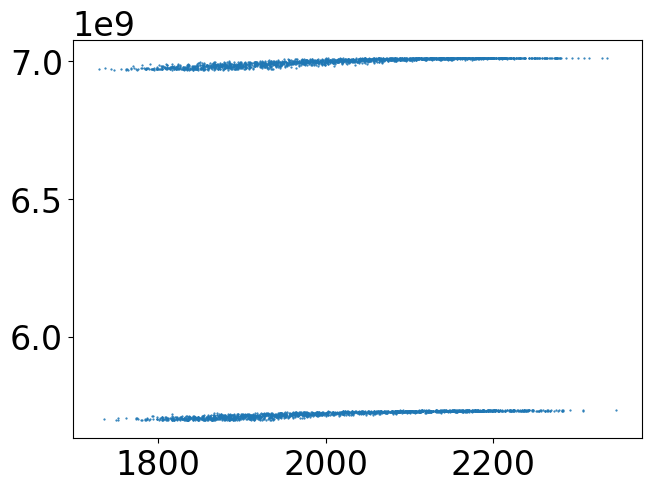

In [290]:
idx = 5
plt.scatter(X[:, idx, 1], P1[:, idx], s=.3)

In [273]:
X.shape

(4000, 50, 2)

In [215]:
Y[:2000, 0, 1].shapez

(2000,)

In [216]:
P[:2000, 0].shape

(2000,)

In [218]:
P[:2000, 0]

array([68089629.03909901, 68089629.00159505, 68089582.93231407, ...,
       48102700.64342694, 48102073.22124079, 48101543.08730958])

In [217]:
Y[:2000, 0, 1]

array([214.14812922, 214.14812912, 214.1476698 , ..., 223.20074269,
       223.201918  , 223.20291032])